# Examples



*First prepare for clinical informations about a group of patients, then try the following method* 

> <span style="font-size:1.2em;">**Build model and load model weights (Refer to run.ipynb for details).**</span>

In [ ]:
from resnet3d import Model
import numpy as np
import tensorflow as tf
from keras.models import model_from_json
from keras.models import load_model
model = Model(128, 128, 20)
model.build(input_shape= (32, 20, 128, 128, 3))
model.load_weights(r"./model/A4C_resnet3d_0.h5")

> <span style="font-size:1.2em;">**PAH_data is the dataframe storing the retrieved clinical information.**</span>\
> *Check out the format and required data columns in our PAH survival analysis as follows*\
> *Patient IDs were removed for deidentification*

In [ ]:
import csv
import pandas as pd
for i in range(len(PAH_data)):
    model_output, prob= model(PAH_data(lid))
    PAH_data.loc[i, 'RV_model']= float(prob[0][0])

In [17]:
PAH_data

,RV_model,event,Age,Gender,DM,HTN,HF,Af,CKD,LVEF,E/E' (Mean),months,HCM,HL,CAD
0,0.624408,0,59.1,1,1,1,0,0,1,76.30,11.500,46,0.0,0.0,0.0
1,0.491257,0,59.4,2,0,1,0,0,0,77.97,6.807,77,0.0,0.0,0.0
2,0.019553,1,48.3,2,0,1,0,0,0,68.35,8.468,6,0.0,1.0,0.0
3,0.712456,0,26.8,2,0,0,0,0,0,77.35,9.194,82,0.0,0.0,0.0
4,0.755993,1,49.1,1,0,1,0,0,0,65.00,5.500,2,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.584913,0,71.7,1,0,0,0,0,0,29.60,13.300,6,0.0,0.0,0.0
141,0.780517,0,66.8,2,0,0,0,0,0,78.10,10.900,27,0.0,0.0,0.0
142,1.000772,0,61.3,1,0,0,0,0,0,60.62,4.566,27,0.0,0.0,0.0
143,0.372582,1,44.0,2,0,0,0,0,0,66.70,10.700,0,0.0,0.0,0.0


> <span style="font-size:1.2em;">**Conduct univaraite analysis for variable selection.**</span>\
> *Log rank test is used for comparing the survival distributions of two or more groups.*


In [18]:
from lifelines.statistics import logrank_test
# use gender as a binary indicator variable
m = (pred_df["Gender"]==1) #condition
result = logrank_test(pred_df[m]['event'], pred_df[~m]['event'], pred_df[m]['months'], pred_df[~m]['months'])

In [19]:
result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.20 0.66      0.60

Use the method and check if there is a statistically significant difference between the survival distributions of the groups being compared.
For those of the continuous variables, say 'Age', either set a threshold and categorize them, or treat them as different groups and use multivariate log rank test for analysis.

> <span style="font-size:1.2em;">**Cox Proportional Hazards Model**</span>\
> *Select some important variables based on log rank test, and use them for multivariate survival analysis.*


In [20]:
import pandas as pd
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(PAH_data.drop(columns= ["DM", "HTN","HL", "HF", "CKD", "HCM", "CAD"]), duration_col = 'months', event_col = 'event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 145 total observations, 92 right-censored observations>
             duration col = 'months'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 145
number of events observed = 53
   partial log-likelihood = -228.73
         time fit was run = 2024-07-19 05:38:19 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
RV_model      0.78       2.18       0.30             0.20             1.36                 1.22                 3.90
Age          -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
Gender       -0.02       0.98       0.38            -0.77             0.73                 0.46                 2.08
Af            0.96       2.61       0.40             0.17             1.75                 1.18                 5.77
LVEF         -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
E/E' (Mean)   0.02       1.02       0.03            -0.03             0.08                 0.97                 1.08

              cmp to     z    p   -log2(p)
covariate                                 
RV_model        0.00  2.64 0.01       6.89
Age             0.00 -0.74 0.46       1.13
Gender          0.00 -0.05 0.96       0.05
Af              0.00  2.38 0.02       5.84
LVEF            0.00 -2.29 0.02       5.52
E/E' (Mean)     0.00  0.83 0.41       1.30
---
Concordance = 0.68
Partial AIC = 469.46
log-likelihood ratio test = 20.01 on 6 df
-log2(p) of ll-ratio test = 8.50

In [23]:
cph.hazard_ratios_

covariate
RV_model       2.182930
Age            0.992635
Gender         0.982497
Af             2.613579
LVEF           0.964320
E/E' (Mean)    1.023001
Name: exp(coef), dtype: float64

<Axes: xlabel='log(HR) (95% CI)'>

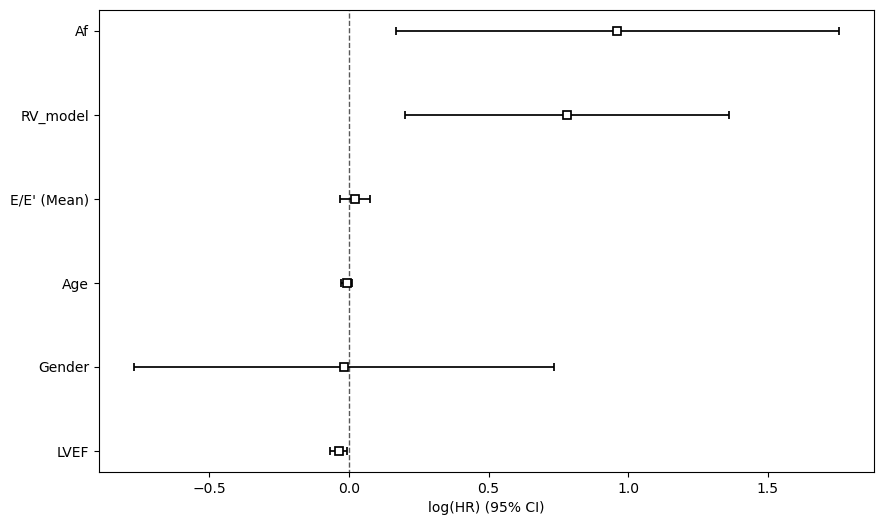

In [24]:
import matplotlib.pyplot as plt
plt.subplots(figsize = (10, 6))
cph.plot()

> <span style="font-size:1.2em;">**Plot the survival curves with CPH fitter**</span>\
> *Check out the curves for RV_model=0 and 1, and Gender=0 and 1 as follows. It's apparent that different gender(p=0.96) does not influnece the prognosis of PAH patients while the confidence level of RVD does.*

<Axes: title={'center': 'B.'}, xlabel='months'>

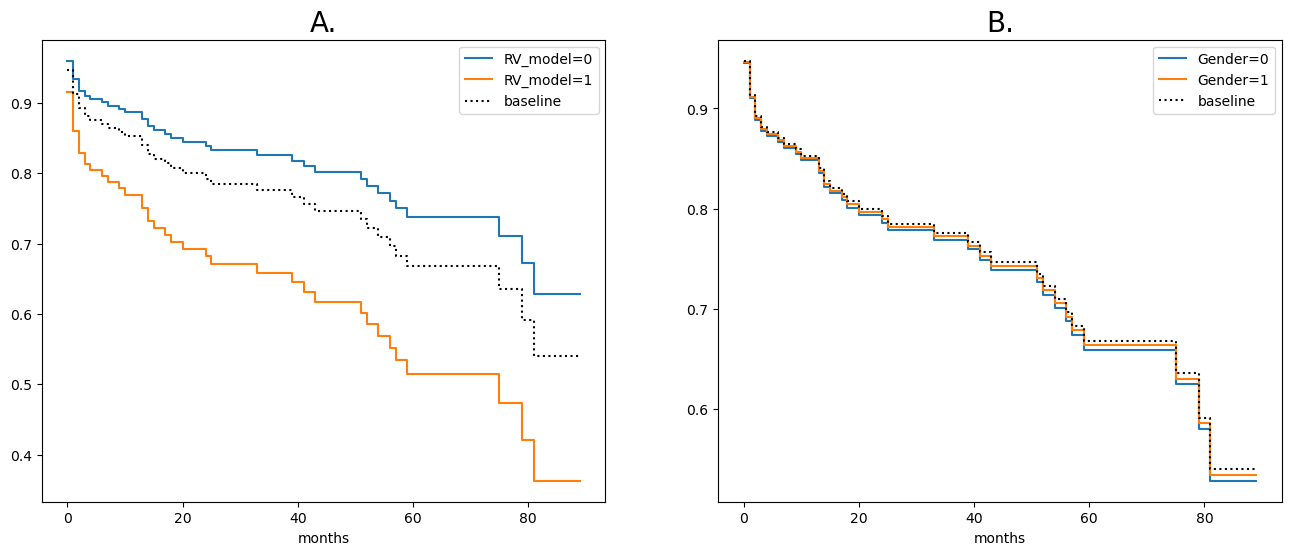

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
ax= plt.subplot(121, xlabel= 'months')
ax.set_title('A.', fontsize=20)
cph.plot_partial_effects_on_outcome("RV_model", [0, 1], ax= ax)

ax= plt.subplot(122, xlabel= 'months')
ax.set_title('B.', fontsize=20)
cph.plot_partial_effects_on_outcome("Gender", [0, 1], ax= ax)

> <span style="font-size:1.2em;">**Additional Estimation**</span>\
> *If you're interested in how a single variable may affect the survival curve of these patients,*    \
> *Kaplein-Meier Curve might be able to give you a brief and clear estimation.*

Text(0.5, 1.0, 'Survival of different groups')

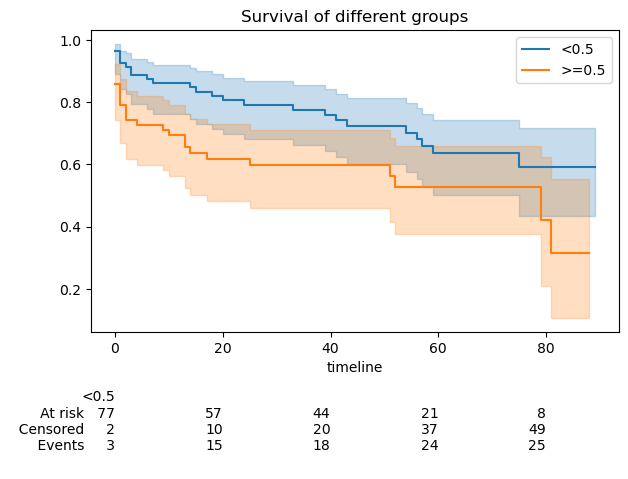

In [27]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
m = (PAH_data["RV_model"] >= 0.5)
kmf.fit(PAH_data['months'][~m], event_observed = PAH_data['event'][~m], label = "<0.5")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
kmf.fit(durations = PAH_data['months'][m], event_observed = PAH_data['event'][m], label = ">=0.5")
kmf.plot_survival_function(ax = ax)

plt.title("Survival of different groups")